<a href="https://colab.research.google.com/github/Leerish/Deep-Learning-Notebooks/blob/main/Transfer_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3 : Scaling - up (Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning , now it's time to scale up all of the classes in Food 101

Our Goal is to beat the orginal model Food101 paper with 10% of the training

Orginal Food101paper:https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our Baseline to Beat is 50.76% accuracy across 101 classes


**Whole Notebook can be accessed here** :https://colab.research.google.com/drive/1tsuQzJypFTc9B1XsRZUR8vsl4P0ZlaY2

## Creating Helper Functions

Importing Helper Functions

In [ ]:
# Helper Functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-06 12:07:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-06 12:07:34 (51.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Importing helper functions

from helper_functions import  create_tensorboard_callback , plot_loss_curves , unzip_data , compare_historys , walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat original Food101 paper with 10% of the training data , so download it

The data we're downloading comes from original Food101 dataset but has been preprocessed using the image data modification notebook : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
# Downloading data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-12-06 12:07:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 173.194.218.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  47.9MB/s    in 18s     

2023-12-06 12:08:03 (88.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
# Setting up training and testing data directories

train_dir_10_percent = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


In [ ]:
# Data Walkthrough

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_f

In [ ]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE =(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode ="categorical",
                                                                          image_size = IMG_SIZE,
                                                                          batch_size = 32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                shuffle = False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a Big Pin Model with Transfer Learning on 10% of 101 food classes

Here are steps we're going to take:
* Create a ModelCheckpoint callback
* Create a Data Augmentation Layer to build data augmentation right into the model
* Build a headless (No top layer) Functional EfficientNetB0 backboned-model
* Compile the model
* Feature Extract for 5 full passes ( 5 epochs on the train dataset and validate on 15% of test data , to save epoch time)

In [ ]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Data Augmentation Layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup Data Augmentation
data_aug = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
] , name = "data_augementation")

In [ ]:
# Setup the base model and freeze the layers(this will extract features)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable= False

# Setup Model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3) , name ="input_layer")

x = data_aug(inputs) # augment images only in training data

x = base_model( x , training= False) # Puts the model in inference mode so weights which need to stay frozen ,stay frozen

x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation ="softmax" , name="output_layer")(x)

model = tf.keras.Model(inputs , outputs)


24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# Get the summary of our model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augementation (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compile the model

model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
# Fitting the model

history_1 = model.fit(train_data_all_10_percent,
                      epochs = 5 ,
                      validation_data = test_data ,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback("full_model_experiments" , experiment_name ="experiment_1") , checkpoint_callback])

Saving TensorBoard log files to: full_model_experiments/experiment_1/20231206-110422
Epoch 1/5
237/237 [==============================] - 124s 454ms/step - loss: 3.5281 - accuracy: 0.2354 - val_loss: 2.7960 - val_accuracy: 0.3763
Epoch 2/5
237/237 [==============================] - 80s 337ms/step - loss: 2.4250 - accuracy: 0.4481 - val_loss: 2.3271 - val_accuracy: 0.4415
Epoch 3/5
237/237 [==============================] - 67s 281ms/step - loss: 2.0526 - accuracy: 0.5143 - val_loss: 2.0883 - val_accuracy: 0.4883
Epoch 4/5
237/237 [==============================] - 60s 251ms/step - loss: 1.8421 - accuracy: 0.5537 - val_loss: 2.0205 - val_accuracy: 0.4889
Epoch 5/5
237/237 [==============================] - 55s 229ms/step - loss: 1.6901 - accuracy: 0.5873 - val_loss: 1.9506 - val_accuracy: 0.5024


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Evaluate on the whole dataset
model.evaluate(test_data)

790/790 [==============================] - 59s 75ms/step - loss: 1.6176 - accuracy: 0.5788


[1.6175564527511597, 0.5787723064422607]

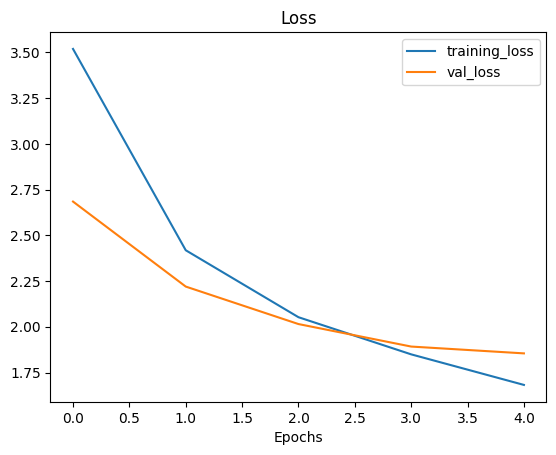

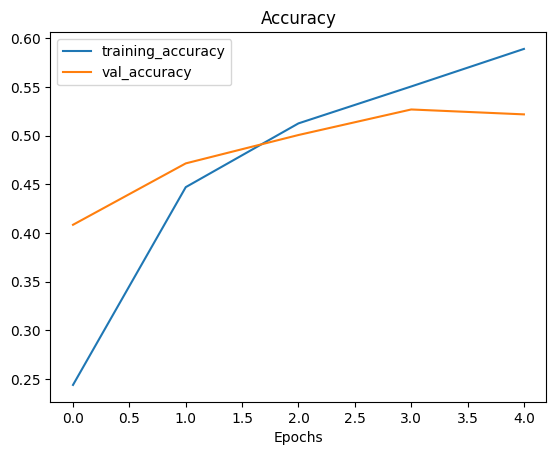

In [ ]:
plot_loss_curves(history_1)

Two curves in the above model should be very similar to each other , they represent over fitting of data

## Fine Tuning our model

In [ ]:
# Unfreeze all the layers in our model

base_model.trainable= True

# Refreeze every layer except the last 5 layers

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile the model with lower learning rate with fine tuning

model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Lowering by 10%
              metrics =["accuracy"])

In [ ]:
# Which layers are trainable ?

for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augementation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable

for layer_number , layer in enumerate(model.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [ ]:
# Fine-tune the model for another 5 epochs

fine_tune_epochs = 10

# Fine-tune our model

history_2 = model.fit(train_data_all_10_percent ,
                      epochs = fine_tune_epochs,
                      validation_data = test_data ,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 49s 202ms/step - loss: 1.5784 - accuracy: 0.6116 - val_loss: 1.9008 - val_accuracy: 0.5140
Epoch 6/10
237/237 [==============================] - 45s 188ms/step - loss: 1.4983 - accuracy: 0.6261 - val_loss: 1.8462 - val_accuracy: 0.5244
Epoch 7/10
237/237 [==============================] - 47s 195ms/step - loss: 1.4129 - accuracy: 0.6484 - val_loss: 1.8282 - val_accuracy: 0.5201
Epoch 8/10
237/237 [==============================] - 44s 186ms/step - loss: 1.3419 - accuracy: 0.6634 - val_loss: 1.8415 - val_accuracy: 0.5201
Epoch 9/10
237/237 [==============================] - 44s 183ms/step - loss: 1.2733 - accuracy: 0.6844 - val_loss: 1.7865 - val_accuracy: 0.5336
Epoch 10/10
237/237 [==============================] - 41s 169ms/step - loss: 1.2294 - accuracy: 0.6904 - val_loss: 1.8179 - val_accuracy: 0.5294


In [ ]:
# Evaluate on whole test data
model.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 1.4747 - accuracy: 0.6050


[1.474665641784668, 0.6050297021865845]

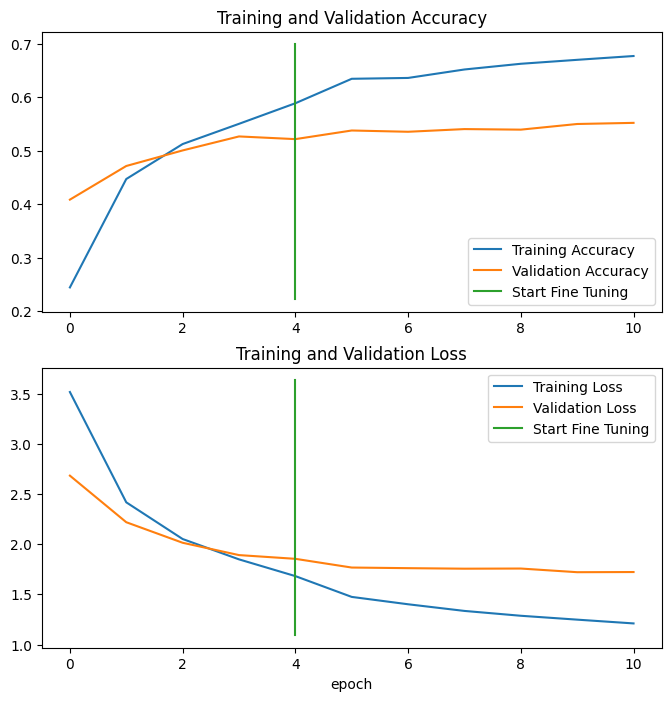

In [ ]:
compare_historys(original_history=history_1 , new_history  = history_2)

## Saving and Loading our model

To use our model in an external application , we'll need to save and export it to somewhere

In [ ]:
# Save our Fine-tunning model
model.save("101_classes_model")

## Evaluating the performance of our model across all different classes

Let's make some predictions , visualize them and then later find out which predictions were wrong

In [ ]:
import tensorflow as tf
# Download pretrained model (one that was prepared earlier , so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2023-12-06 11:22:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   149MB/s    in 0.3s    

2023-12-06 11:22:35 (149 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in the saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model

result_1 = model.evaluate(test_data)

790/790 [==============================] - 69s 84ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our Trained model

In [ ]:
# Make Predictions with model

pred_probs = model.predict(test_data , verbose = 1)

NameError: ignored

In [ ]:
len(pred_probs)

25250

In [ ]:
# shape of our predictions
pred_probs.shape

(25250, 101)

In [ ]:
# Let's see the first 10 predictions
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
pred_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

Our Model outputs a prediction probability array (With N number of variables , where N is the number of classes)for each sample passed to the predict method

In [ ]:
# We get one prediction probability per class ( in our case there are 101 prediction probabilities )

print(f"Number of prediction probabilities for sample 0:{len(pred_probs[0])}")
print(f"What prediction probability sample 0 look like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0:{pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0:101
What prediction probability sample 0 look like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-05

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each level
pred_classes = pred_probs.argmax(axis = 1)

pred_classes[:10]

NameError: ignored

Now we have got the predictions array of all of our model's predictions , to evaluate them , we need to compare them to labels

In [ ]:
# To get our test labels we need to unravel our test data BatchDataset
y_labels=[]

for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

NameError: ignored

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [ ]:
# Lets try scikit-learn's accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score( y_true = y_labels , y_pred = pred_classes)
sklearn_accuracy

NameError: ignored